In [1]:
import Rk4 
import read_coils as rc
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import imp
import json
import pandas as pd
imp.reload(Rk4)

<module 'Rk4' from 'C:\\Users\\Johansell Villalobos\\Estudiantes ITCR\\Team Channel - Top Secret\\Codes\\Johan\\MHD\\mhdequilibrium\\Medusa\\Campo Medusa\\Rk4.py'>

In [14]:
data = rc.read_coil('coils.txt')
print(data.shape)

(12, 361, 4)


In [3]:
def order(data):
    x, y, z, *_ = data.T
    
    R = np.sqrt(x**2+y**2)
    R0 = 0.5*(max(R)-min(R))+min(R)
    phi = np.arctan2(y,x)

    theta = np.arctan2(z, (R-R0))+np.pi
    theta, ind = np.unique(theta,return_index=True)
    data = data[ind]       
    
    last = data[0].copy()
    last[3] = 0
    
    data = np.append(data, [last], axis=0)
    return data


In [7]:
def order_coords(data):
    data_temp = []
    for i in range(len(data)):
        dat = order(data[i])
        data_temp.append(dat)
    return np.array(data_temp)

ordereddata = order_coords(data)
ordereddata.T[0:3] *= 1e-3
ordereddata.T[3] *= -1

In [8]:
def carttocil2(data, C):
    x, y, z, *_ = data.T
    
    R = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x) + np.pi
    cur = C*np.ones(len(x))
    cur[-1] = 0

    return np.array([R, phi, z, cur])

In [9]:
lis = ordereddata.tolist()
with open("coilsmedusaordenadas.txt", "w+") as f:
    f.write(json.dumps(lis))

In [10]:
with open("coilsmedusaordenadas.txt") as f:
    datos=f.read()
    arreglo =np.array(json.loads(datos))

In [11]:
def cilorder(data):
    x, y, z, *_ = data.T
    
    R = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)+np.pi
    ind = np.argsort(phi)
    
    data = data[ind]       
    last = data[0].copy()
    last[3] = 0
    
    data = np.append(data, [last], axis=0)
    
    return data

Csup = pd.read_excel('CSup.xls')
Cinf = pd.read_excel('CInf.xls')

Csup = np.array(Csup)*1e-3
Cinf = np.array(Cinf)*1e-3

coorsup = np.zeros((Csup.shape[0],4))
coorsup[:,0:3] = Csup

coorinf = np.zeros((Cinf.shape[0],4))
coorinf[:,0:3] = Cinf

coorsup[:,3] = 3e3
coorinf[:,3] = -3e3

coorsup = cilorder(coorsup)
coorinf = cilorder(coorinf)


In [12]:
VFcoils = np.array([coorsup,coorinf])

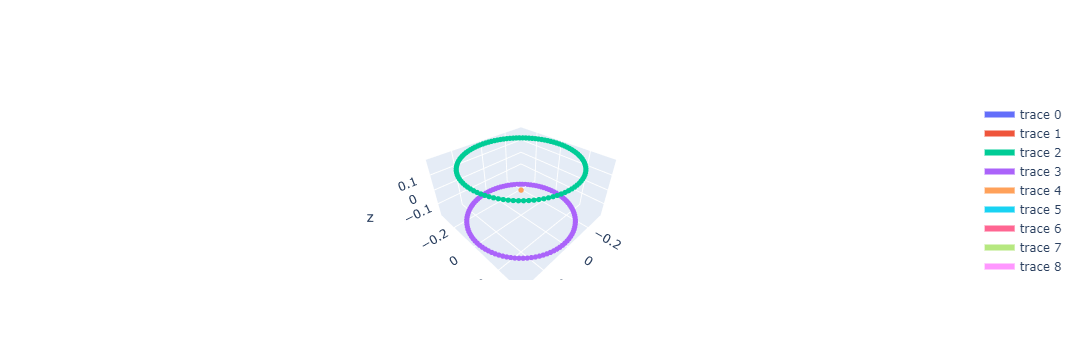

In [13]:
layout = go.Layout(
            scene=dict(
                aspectmode='data'
            ))
fig = go.Figure(layout=layout)

for i in ordereddata: 
    x, y, z, _= i.T
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, 
                               line=dict(width=6),
                               marker=dict(size=0)))
    
xcsup, ycsup, zcsup, *_ = coorsup.T
xcinf, ycinf, zcinf, *_ = coorinf.T

    
fig.add_trace(go.Scatter3d(x=xcsup,y=ycsup,z=zcsup,
                           line=dict(width=6),
                           marker=dict(size=0)))
fig.add_trace(go.Scatter3d(x=xcinf,y=ycinf,z=zcinf,
                           line=dict(width=6),
                           marker=dict(size=0)))
fig.show()

In [ ]:
#solenoid field integration

def Br(theta, r, z, L, a, mi, n, i):
    
    C = -a*mi*n*i/(2*np.pi)
    sqrt1 = 1/np.sqrt((z+L/2)**2+r**2+a**2-2*a*r*np.cos(theta))
    sqrt2 = 1/np.sqrt((z-L/2)**2+r**2+a**2-2*a*r*np.cos(theta))
    return C*np.cos(theta)*(sqrt1 - sqrt2)

def Bz(theta, r, z, L, a, mi, n, i):
    
    C = a*mi*n*i/(2*np.pi)
    sqrt1 = (z-L/2)/((r**2+a**2-2*a*r*np.cos(theta))*np.sqrt((z+L/2)**2+r**2+a**2-2*a*r*np.cos(theta)))
    sqrt2 = (z+L/2)/((r**2+a**2-2*a*r*np.cos(theta))*np.sqrt((z-L/2)**2+r**2+a**2-2*a*r*np.cos(theta)))  
    
    return C*(a-r*np.cos(theta))*(sqrt1-sqrt2)

In [11]:
from scipy.integrate import quad

In [35]:
r = np.linspace(0.04,0.3, num =100)
z = np.linspace(-0.13, 0.13, num =100)
R, Z = np.meshgrid(r,z)

In [14]:
import cilcoilbiot as ccb
imp.reload(ccb)

<module 'cilcoilbiot' from 'C:\\Users\\Johansell Villalobos\\Estudiantes ITCR\\Team Channel - Top Secret\\Codes\\Johan\\MHD\\mhdequilibrium\\Medusa\\Campo Medusa\\cilcoilbiot.py'>

In [37]:
B = np.zeros((100,100, 3))

for i in range(100): 
    for j in range(100):
        point = np.array([R[i,j], 0, Z[i,j]])
        B[i,j] = ccb.biot(ordereddata, point)
        

In [ ]:
Bsol = np.zeros((100,100,3))

for i in range(100): 
    for j in range(100):
        br = quad(Br,0, np.pi, args = (R[i,j], Z[i,j], 0.68, 0.027, 4*np.pi*1e-7,188,16000))[0]
        bz = quad(Bz,0, np.pi, args = (R[i,j], Z[i,j], 0.68, 0.027, 4*np.pi*1e-7,188,16000))[0]
        Bsol[i,j] = [br, 0, bz]

In [ ]:
BVF = np.zeros((100,100,3))

for i in range(100): 
    for j in range(100):
        point = np.array([R[i,j], 0, Z[i,j]])
        BVF[i,j] = ccb.biot(VFcoils, point)

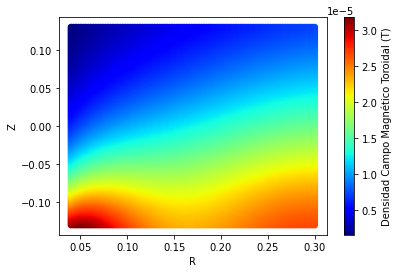

NameError: name 'Bsol' is not defined

In [40]:
plt.scatter(R,Z, c = B[:,:,2], cmap='jet')
plt.xlabel('R')
plt.ylabel('Z')
plt.colorbar(label='Densidad Campo Magnético Toroidal (T)')
plt.show()


plt.scatter(R,Z, c = Bsol[:,:,2], cmap='jet')
plt.xlabel('R')
plt.ylabel('Z')
plt.colorbar(label='Densidad Campo Magnético Radial (Solenoide) (T)')
plt.show()


plt.scatter(R,Z, c = BVF[:,:,2], cmap='jet')
plt.xlabel('R')
plt.ylabel('Z')
plt.colorbar(label='Densidad Campo Magnético Vertical (Bobinas VF) (T)')
plt.show()



In [ ]:
r2 = np.linspace(0.04, 0.3, num =20)
z2 = np.linspace(-0.14, 0.14, num =20)
R2, Z2 = np.meshgrid(r2,z2)

In [ ]:
B2 = np.zeros((20,20,3))

for i in range(20): 
    for j in range(20):
        point = np.array([R2[i,j], 0, Z2[i,j]])
        B2[i,j] = ccb.biot(ordereddata, point)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,10))


c1 = axs[0,0].scatter(R, Z, c=B[:,:,1], cmap='jet')
axs[0,0].set_xlabel('R-Axis')    
axs[0,0].set_ylabel('Z-Axis')
axs[0,0].set_title('Toroidal Field')

c2 = axs[0,1].scatter(R, Z, c=B[:,:,0], cmap='jet')
axs[0,1].set_xlabel('R-Axis')    
axs[0,1].set_ylabel('Z-Axis')
axs[0,1].set_title('Radial Field')

c3 = axs[1,0].scatter(R, Z, c=B[:,:,2], cmap='jet')
axs[1,0].set_xlabel('R-Axis')    
axs[1,0].set_ylabel('Z-Axis')
axs[1,0].set_title('Vertical Field')

c4 = axs[1,1].scatter(R, Z, c=B[:,:,1], cmap='jet')
axs[1,1].quiver(R2, Z2, B2[:,:,0], B2[:,:,2])
axs[1,1].set_xlabel('R-Axis')    
axs[1,1].set_ylabel('Z-Axis')
axs[1,1].set_title('Vertical Field')

fig.colorbar(c1, ax=axs[0,0], orientation='vertical', fraction=.1)
fig.colorbar(c2, ax=axs[0,1], orientation='vertical', fraction=.1)
fig.colorbar(c3, ax=axs[1,0], orientation='vertical', fraction=.1)
fig.colorbar(c4, ax=axs[1,1], orientation='vertical', fraction=.1)

fig.show()  
fig.savefig('out.png')

In [15]:
#integracion de ecuacion de linea de campo 
#ajuste de forma de datos para realizar la integración
init_pos = np.array([0.2,0.000000e+00,0.000000e+00])
linedata, _ = Rk4.RK4(1000, 25000, init_pos, data)

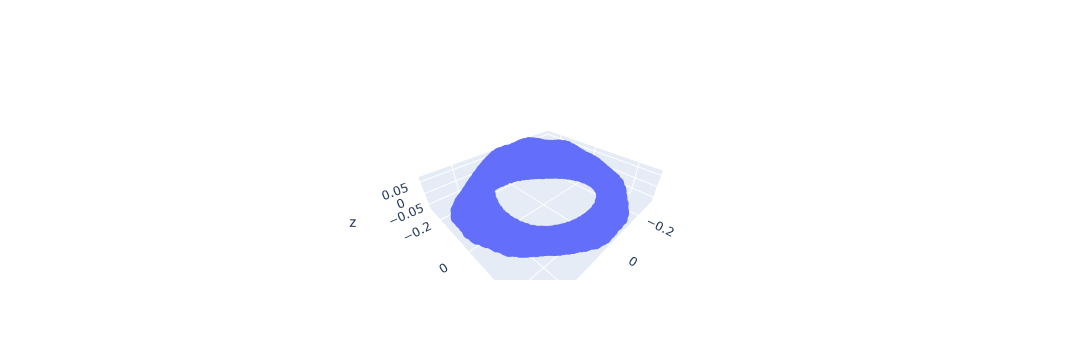

In [16]:
x,y,z, *_ = linedata[0:20000].T

layout = go.Layout(
            scene=dict(
                aspectmode='data'
            ))
fig2 = go.Figure(layout=layout)


fig2.add_trace(go.Scatter3d(x=x, y=y, z=z))
    
fig2.show()
